<a href="https://colab.research.google.com/github/petron23/ML_random_projects/blob/main/MNIST_classification_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")


device = "cuda" if torch.cuda.is_available() else "cpu"

PyTorch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [ ]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 13300258.37it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 307746.90it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5056389.35it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19159074.53it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
print(train_data.classes, train_data.transforms, train_data.targets, len(train_data.data), len(train_data.targets))

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] StandardTransform
Transform: ToTensor() tensor([9, 0, 0,  ..., 3, 0, 5]) 60000 60000


In [ ]:
image, label = train_data[0]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
9


Image shape: torch.Size([1, 28, 28])


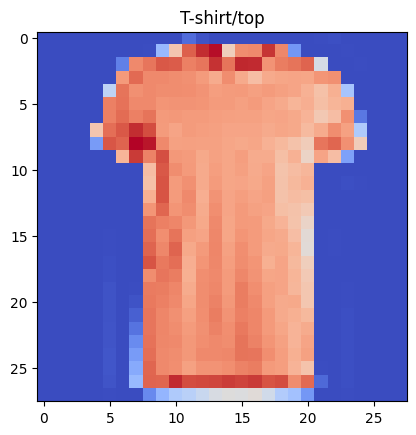

In [ ]:
image, label = train_data[17]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap = "coolwarm")
plt.title(train_data.classes[label]);

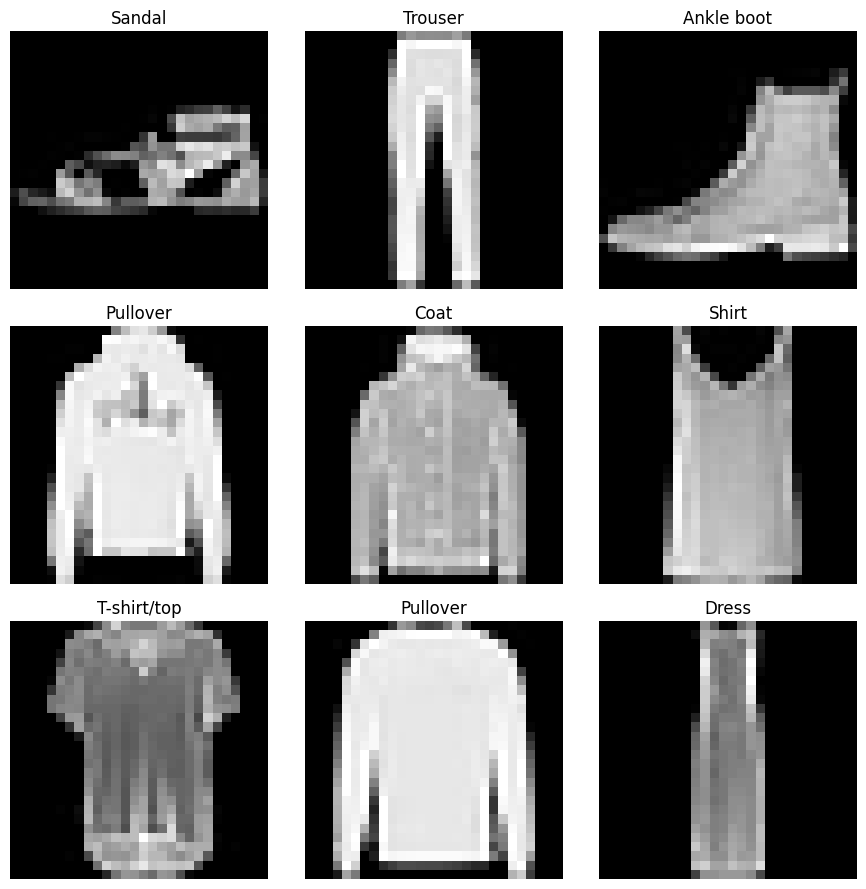

In [ ]:
import random

torch.manual_seed(42)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for ax in axs.flat:
    random_idx = random.randint(0, len(train_data) - 1)
    img, label = train_data[random_idx]

    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(train_data.classes[label])
    ax.axis('off')

plt.tight_layout()


In [ ]:
#Loading data
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7d64fde07460>, <torch.utils.data.dataloader.DataLoader object at 0x7d64fdc794e0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 9, label size: torch.Size([])


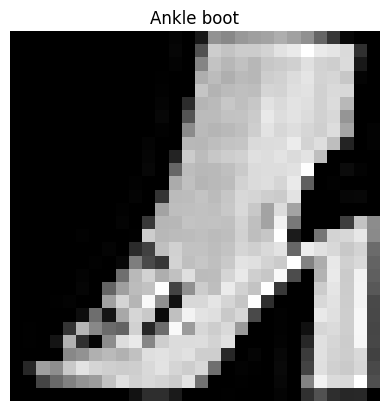

In [ ]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis("Off")

print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")


## Model 0 --> linear model

In [ ]:
from torch import nn

class MNISTClassif(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
      super().__init__()
      self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )
    def forward(self, x):
      return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

model_0 = MNISTClassif(input_shape=784,
    hidden_units=10,
    output_shape=len(train_data.classes)
)
model_0.to("cpu")

MNISTClassif(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [25]:
!pip install torchmetrics

import torchmetrics

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(train_data.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.1)

In [26]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [27]:
#creating a timer function
import time

def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function {func.__name__} took {elapsed_time:.4f} seconds to execute.")
        return result
    return wrapper

In [28]:
# Let's define a training_step function

def training_step(model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            accuracy_fn,
            device: torch.device = device):
    train_loss, train_acc = 0,0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss
        train_acc += accuracy_fn(y_gt = y, y_pred = y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [30]:
# Let's define a test_step function

def test_step(model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            accuracy_fn,
            device: torch.device = device):

   test_loss, test_acc = 0,0
   model.to(device)
   model.eval()
   with torch.inference_mode():
        for X, y in data_loader:
          X, y = X.to(device), y.to(device)
          test_pred = model(X)
          loss = loss_fn(test_pred,y)
          test_loss += loss
          test_acc += accuracy_fn(y_gt = y, y_pred = test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [34]:
@timer
def looping(model, epochs=10):
  torch.manual_seed(42)
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    training_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )


In [ ]:
# creating models

# linear dense model
class dense_v0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)


# non-linear dense model
class dense_v1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)


# non-linear dense model nonlin start
class dense_v2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [37]:
looping(model= dense_v0(784,2,3),epochs = 10 )

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0
---------


IndexError: ignored

In [ ]:
epochs = 3
model = dense_v1

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------


NameError: ignored

In [ ]:
device

'cuda'

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
@timer
def looping(model, epochs=10):
  torch.manual_seed(42)
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'